# Stock Market Analysis

### In the following program we will calculate the returns on a stock over 5 years



In [291]:
### Packages required for web scrapping
from bs4 import BeautifulSoup
from lxml import html
from selenium import webdriver
import time

# packages for data visualization
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib
import matplotlib.pyplot as plt
import mplfinance as mpf

# For adbvanced data manipulation
import pandas as pd

In [292]:
def web_scrape(symbol):

        
        # Start the Driver
        driver = webdriver.Chrome(executable_path = r"C:\Webdriver\chromedriver.exe")
        
        URL = f'https://finance.yahoo.com/quote/{symbol}/history?period1=1449187200&period2=1607040000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true'
        
        # Hit the url of Yahoo Finance and wait for 1 minute
        driver.get(URL)
        time.sleep(60)
        
        # Driver scrolls down 13 times to load the table.
        for i in range(0,13):
            driver.execute_script("window.scrollBy(0,5000)")
            time.sleep(20)
        
        
        
        # Fetch the webpage and store in a variable.
        webpage = driver.page_source
        
        # Web page fetched from driver is parsed using Beautiful Soup.
        HTMLPage = BeautifulSoup(driver.page_source, 'html.parser')

        # Table is searched using class and stored in another variable.
        Table = HTMLPage.find('table', class_='W(100%) M(0)')
        
        # List of all the rows is store in a variable 'Rows'.
        Rows = Table.find_all('tr', class_='BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)')

        #print(Rows)

        # Convertinh data received to String
        data_table = html.fromstring(driver.page_source)

        # Data required is table rows therefore we are looking for the <tr> tag
        table_rows = data_table.xpath('//tr')
        
        return table_rows
        

In [293]:
def convert_to_list(table_rows):
    
    table_data = []
    dividends = []
    i = 0
    k = 0
    
    # Storing the header in the empty list (The First Row of the table)
    for t in table_rows[0]:
        i = i + 1
    
        # Extracting the name of the table header
        name = t.text_content().replace("*", "")
        #print(f'{i}: {name}')
    
        if name == 'Date':
            dividends.append((name, []))
    
        # Appending the name to the header column
        table_data.append((name, []))

    dividends.append(('Dividends', []))
    #print(dividends)
    
    for row_number in range(1, len(table_rows)):
    
        # Storing data of each row
        row = table_rows[row_number]
        try:
        
            # Every Quater, dividents are released hence we must skip those rows and end if the length is not 7 or 2
            if len(row) != 7:
                if len(row) == 2:
                    continue
                else:
                            break
    
            #i is the index of our column
            i=0
    
            #Iterate through each element of the row
            for row_element in row.iterchildren():
                data=row_element.text_content().replace(',', '').replace('-', '')
        
                #Check if row is empty
                if i>0:
            
                    #Convert any numerical value to integers
                    try:
                        data=float(data)
                    except:
                        pass

                #Append the data to the empty list of the i'th column
                table_data[i][1].append(data)
                i = i +1
        
        except:
            print(i)
            
    # Return both the lists
    return table_data, dividends

In [294]:
def list_to_dataframe(incoming_list):
    # Convert table_data to a dictionary
    dict_list ={title:column for (title,column) in incoming_list}

    # Dictionary can easily be converted to a pandas DataFrame
    df = pd.DataFrame(dict_list)
    
    return df

In [303]:
def calculate_returns(df, df_div):
    year = 2016
    j = 0

    years= [2016, 2017, 2018, 2019, 2020]
    cumulative_div = 0
    yearly_returns = []
    yearly_percent = []
    cumilative = []
    first_close = df['Close'].iloc[-1]
    
    df_div['Date'] = pd.to_datetime(df_div['Date'])
    df['Date'] = pd.to_datetime(df['Date'])
    
    df_div['Year'] = df_div['Date'].dt.year
    df['Year'] = df['Date'].dt.year
    
    
    # Converting the dividends column to Float type
    df_div['Dividends'] = df_div['Dividends'].astype(str).astype(float)
    df['Close'].astype(str).astype(float)

    # Year-wise returns calculations

    for i in range(5):
        # Sum of all Dividends
        df_div_yearly = df_div[df_div['Year'] == (year + i)]
        total_yearly_div = df_div_yearly['Dividends'].sum()
        cumulative_div = cumulative_div + total_yearly_div
    
        # Extracting initial and final close values
        df_yearly = df[df['Year'] == (year + i)]
        
        
            
        initial_close_year = df_yearly['Close'].iloc[[-1]]
        final_close_year = df_yearly['Close'].iloc[[0]]
        
            
        returns = (final_close_year - initial_close_year + total_yearly_div) / initial_close_year * 100
        returns_percent = returns * 100
        cumultive_returns = (final_close_year - first_close + cumulative_div) / first_close * 100
        cumilative.append(cumultive_returns)
        yearly_returns.append(returns)
        yearly_percent.append(returns_percent)

    
    data_tuples = list(zip(years, yearly_returns, yearly_percent, cumilative))
    returns_df = pd.DataFrame(data_tuples, columns = ['Year', 'Returns', '% Return', '% Cumulative'])
    print(returns_df.head())
    return returns_df


In [304]:
def candlestick_plot(df):
    reversed_df = df.iloc[::-1]
    reversed_df['Date'] = pd.to_datetime(reversed_df['Date'])
    daily = reversed_df.tail(60)

    daily.set_index('Date', inplace=True, drop=True)
    daily[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']] = daily[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].apply(pd.to_numeric)
    mpf.plot(daily,type='candle',mav=(3,6,9), volume = True)

In [305]:
def returns_plot(returns_df):
    
    cols = returns_df.columns.drop('Year')
    returns_df[cols] = returns_df[cols].apply(pd.to_numeric, errors='coerce')
    
    ax1 = sns.set_style(style=None, rc=None )

    fig, ax1 = plt.subplots(figsize=(12,6))

    sns.lineplot(data = returns_df['% Cumulative'], marker='o', sort = False, ax=ax1)
    ax2 = ax1.twinx()

    sns.barplot(data = returns_df, x='Year', y='% Return', alpha=0.5, ax=ax2)

In [306]:
def misc_plots(df, symbol):
    reversed_df = df.iloc[::-1]
    reversed_df['Date'] = pd.to_datetime(reversed_df['Date'])
    fig = make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.03,
    specs=[[{"type": "table"}],
           [{"type": "scatter"}],
           [{"type": "scatter"}]]
    )

    fig.add_trace(
        go.Scatter(
            x=reversed_df["Date"],
            y=reversed_df["Open"],
            mode="lines",
            name="Open Price",
        ),
        row=3, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=reversed_df["Date"],
            y=reversed_df["High"],
            mode="lines",
            name="High"
        ),
        row=2
        , col=1
    )

    fig.add_trace(
        go.Table(
            header=dict(
                values=["Open","High", "Low",
                        "Close", "Adj Close", "Volume"],
                font=dict(size=10),
                align="left"
            ),
            cells=dict(
                values=[reversed_df[k].tolist() for k in reversed_df.columns[1:]],
                align = "left")
        ),
        row=1, col=1
    )
    fig.update_layout(
        height=800,
        showlegend=False,
        title_text=f"{symbol} Stats over 5 years",
    )

    fig.show()

In [307]:
def stock_analysis(symbols):
    table_rows = web_scrape(symbols)
    table_data, dividends = convert_to_list(table_rows)
    #print(table_data)
    df = list_to_dataframe(table_data)
    #print(df.head())
    df_div = list_to_dataframe(dividends)
    misc_plots(df, symbols)
    candlestick_plot(df)
    returns_df = calculate_returns(df, df_div)
    print(returns_df)
    returns_plot(returns_df)

In [308]:
symbols = ['LUV', 'DAL', 'UAL', 'ALK']
comparison = pd.DataFrame([])

C:\Users\Abhishek\AppData\Roaming\Python\Python36\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



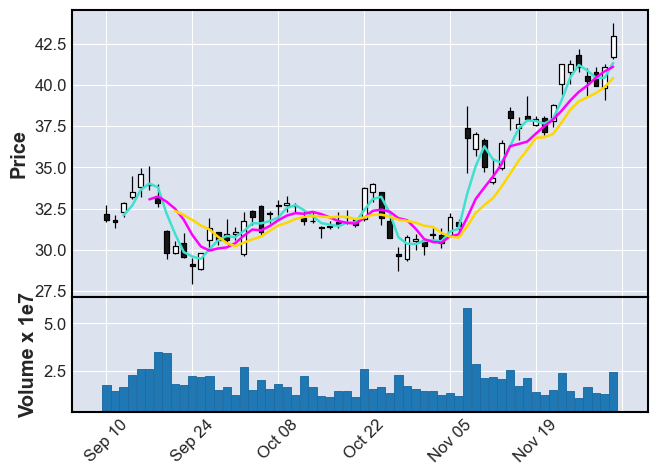

        Date   Open   High    Low  Close  Adj Close      Volume  Year
0 2020-12-03  41.70  43.76  41.56  42.95      42.95  24495100.0  2020
1 2020-12-02  39.81  41.28  39.06  41.07      41.07  12904300.0  2020
2 2020-12-01  40.79  41.06  39.92  39.96      39.96  13184200.0  2020
3 2020-11-30  40.53  41.05  39.35  40.25      40.25  16703900.0  2020
4 2020-11-27  41.79  42.19  40.78  41.06      41.06  10516600.0  2020
   Year                                            Returns  \
0  2016  988    NaN
1239   NaN
Name: Close, dtype: float64   
1  2017    737   NaN
987   NaN
Name: Close, dtype: float64   
2  2018    486   NaN
736   NaN
Name: Close, dtype: float64   
3  2019    234   NaN
485   NaN
Name: Close, dtype: float64   
4  2020    0     NaN
233   NaN
Name: Close, dtype: float64   

                                            % Return  \
0  988    NaN
1239   NaN
Name: Close, dtype: float64   
1    737   NaN
987   NaN
Name: Close, dtype: float64   
2    486   NaN
736   NaN
Name: Close, d

DataError: No numeric types to aggregate

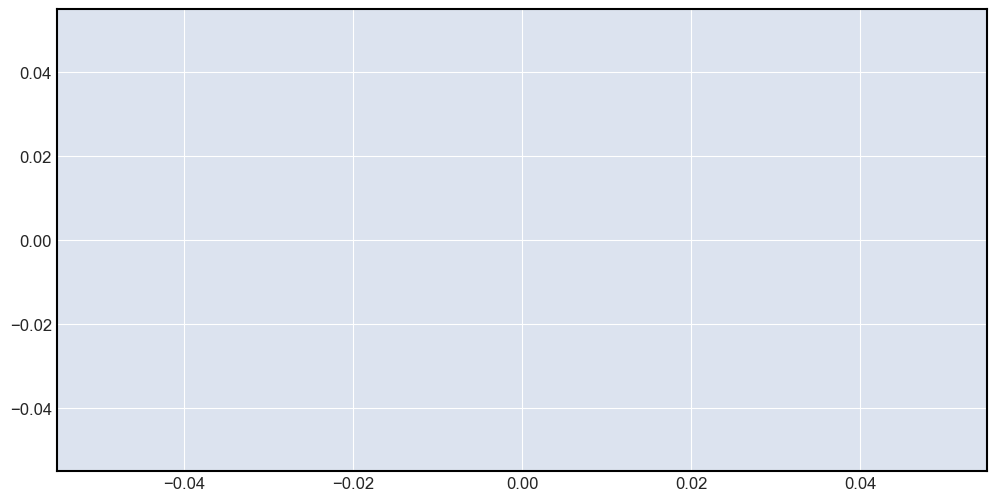

In [310]:
stock_analysis('DAL')

In [ ]:
stock_analysis('ALK')

In [ ]:
comparison.head()